In [8]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import pandas as pd
import rasterio.plot

import overpy
import geopandas as gpd
# import ee
from shapely.geometry import Polygon, box
import os
# import geemap
import json
import multiprocessing

from tqdm import tqdm
import time


In [9]:
# os.chdir('/Users/yer1k/Documents/Master/Duke/2023 Fall/Capstone/solar_wastewater/30_result/')
os.chdir('/Users/yer1k/Library/CloudStorage/GoogleDrive-iamtsubasaozora@gmail.com/My Drive/Capstone Project/Data/')

In [10]:
api = overpy.Overpass()

In [31]:

# Fetch all wastewater treatment plants within California's boundary (# changed to Texas)
query = f"""
    area[admin_level=4]["name"="California"]->.searchArea; 
    (
    way["man_made"="wastewater_plant"](area.searchArea);
    );
    (._;>;);
    out body;
    """

result = api.query(query)

plants = {}

for way in result.ways:
    # Use the name of the plant or its ID if the name is not available
    plant_name = way.tags.get("name", f"Plant_{way.id}")

    # Extract nodes lat and lon without id
    nodes_coords = [(node.lon, node.lat) for node in way.nodes]

    # get rid of "Decimal"  in the coordinates
    nodes_coords = [tuple(map(float, i)) for i in nodes_coords]
    
    plants[plant_name] = nodes_coords

# plants_with_official_name = {key: value for key, value in plants.items() if not key.startswith("Plant_")}


geoms = [Polygon(plants[key]) for key in plants]
df = gpd.GeoDataFrame({'WWTP_name': list(plants.keys()), 'geometry': geoms}, crs="EPSG:4326")
df["centroid"] = df.to_crs('+proj=cea').centroid.to_crs(epsg=4326)



In [32]:
df

,WWTP_name,geometry,centroid
0,Plant_24298754,"POLYGON ((-121.80940 37.69305, -121.80582 37.6...",POINT (-121.80762 37.69120)
1,Plant_24396910,"POLYGON ((-121.78360 36.80423, -121.78363 36.8...",POINT (-121.78025 36.79990)
2,EBMUD Wastewater Treatment Plant,"POLYGON ((-122.29310 37.82285, -122.29238 37.8...",POINT (-122.29525 37.82512)
3,Hyperion Wastewater Treatment Plant,"POLYGON ((-118.42914 33.91957, -118.43162 33.9...",POINT (-118.43006 33.92574)
4,San José–Santa Clara Regional Wastewater Facility,"POLYGON ((-121.95539 37.43062, -121.95452 37.4...",POINT (-121.94663 37.43156)
...,...,...,...
3076,Plant_1225793761,"POLYGON ((-122.65005 38.01477, -122.64995 38.0...",POINT (-122.65182 38.01385)
3077,Tooleville Wastewater Treatment Plant,"POLYGON ((-119.11341 36.28593, -119.11341 36.2...",POINT (-119.11457 36.28416)
3078,Adelanto Wastewater Treatment Plant,"POLYGON ((-117.40319 34.59732, -117.40311 34.5...",POINT (-117.40632 34.59558)
3079,Plant_1229835714,"POLYGON ((-124.14779 41.05681, -124.14801 41.0...",POINT (-124.14792 41.05683)


plotting bounding box:  76%|███████▌  | 202/265 [22:37<03:47,  3.60s/it]

fail to plot San José–Santa Clara Regional Wastewater Facility.tif


plotting bounding box:  95%|█████████▌| 252/265 [27:48<01:39,  7.67s/it]

fail to plot Plant_91374966.zip


plotting bounding box: 100%|██████████| 265/265 [29:23<00:00,  6.65s/it]


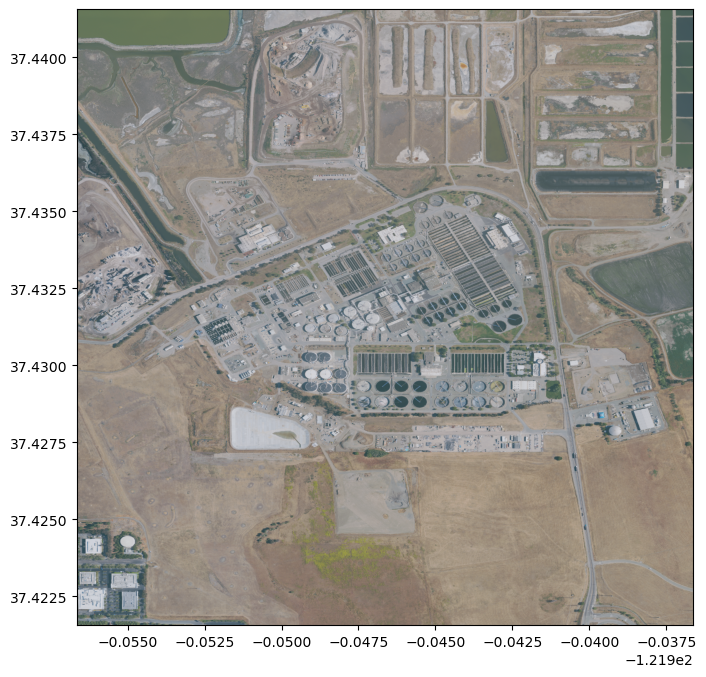

In [34]:
# Added progress bar
# use loop to open the image in tif folder, and plot the bounding box on it
# read all the file names in the folder
directory = 'tif_bounding_box/Images of All 50 States/California'
files = os.listdir(directory)

for file in tqdm(files, desc='plotting bounding box'):
    try:
        with rasterio.open(os.path.join(directory, file)) as src:
            # if file.startswith('download'):
                # continue
            # Read the image data
            img = src.read([1, 2, 3])  # Reads the first three bands for RGB
            # file name without extension
            name = os.path.splitext(file)[0]
            # find the corresponding bounding box
            df_name = df.loc[df['WWTP_name'] == name, :]
            # plot the bounding box
            fig, ax = plt.subplots(figsize=(8,8))
            # Plot the raster
            ax = rasterio.plot.show(img, ax=ax, transform=src.transform)
            # Plot the geometry on the ax axes instance
            df_name.boundary.plot(ax=ax, color='red', linewidth=1.5)
            plt.axis('off')
            # save the figure
            plt.savefig(os.path.join(directory, name + '.png'), bbox_inches='tight', pad_inches=0)
            plt.close()
    except:
        print(f"fail to plot {file}")